In [1]:
#matlab numpy conversion http://mathesaurus.sourceforge.net/matlab-numpy.html

In [4]:
%pylab inline
import scipy as sp
from numba import jit

Populating the interactive namespace from numpy and matplotlib


In [5]:
@jit
def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

In [12]:

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights
            
            
        

In [13]:
sr = 1000/15
freq = 20
waveLength = 1 / freq
waveLengthSamples = waveLength * sr
print("Wavelen: ", waveLength, " secs , " ,waveLengthSamples, ", samples, ", sr , "sr")


Wavelen:  0.05  secs ,  3.333333333333334 , samples,  66.66666666666667 sr


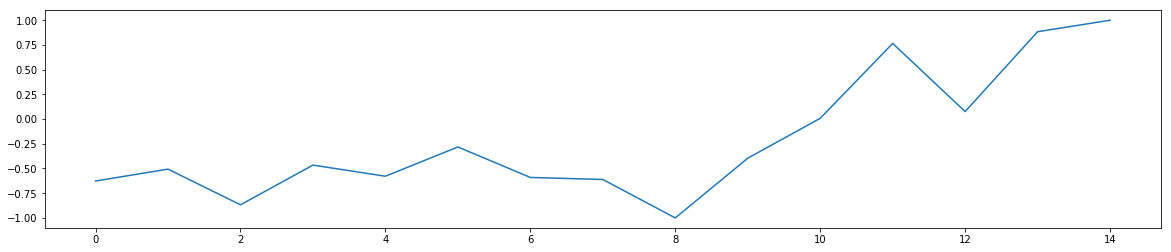

In [36]:
#plot(np.tanh(np.random.randn(10)))
def makeRandomWalk(len):
    pt = zeros(len)
    pt[0] = np.random.randn(1)
    for n in range(pt.size-1):
        pt[n+1] = pt[n] + np.random.randn(1)
    pt = pt - np.min(pt)
    pt = (pt / np.max(pt) * 2) - 1
    return pt
    

#plot()
plot(makeRandomWalk(15))

[ 0.7698763   1.50552792]


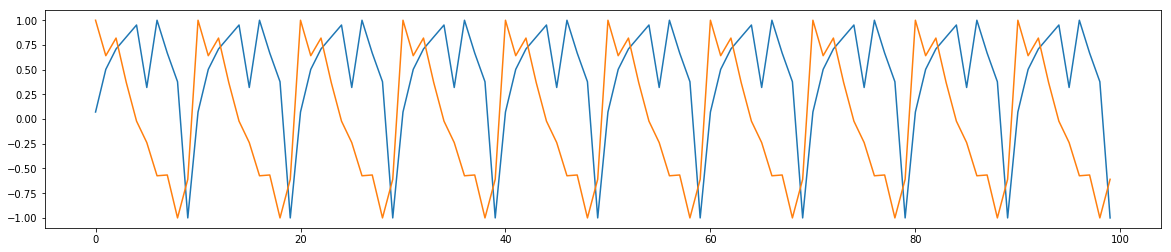

In [209]:
figsize(20,4)
# pSaw = lambda n: (round(n % waveLengthSamples) / waveLengthSamples * 2) - 1.0
# plot([pSaw(x) for x in arange(300)])
# pPulse = lambda n: (((n % waveLengthSamples) < (waveLengthSamples * 0.5)) * 2) - 1.0
# plot([pPulse(x) for x in arange(300)])
# pSine2 = lambda n: (sin(n) * sin((n+pi/4)/6))
# plot([pSine2(x) for x in arange(100)])
# pSine3 = lambda n: (sin(n) * sin((n/4)/6)/6)
# plot([pSine3(x) for x in arange(100)])

pJ1 = lambda n: 1 * sin(2 * pi * n / 3.1504531)
# plot([pJ1(x) for x in arange(100)])
pJ1b = lambda n, d: 1 * sin(n/d) ** 1
# plot([pJ1b(x,2) for x in arange(100)])

period2 = 2
rawp = np.random.randn(period2)
# rawp = np.array([1.1929,2.6856]);
maxVal = np.max(rawp)
minVal = np.min(rawp)
print(rawp)
rp = 0.5 * (2 * (rawp - minVal) / (maxVal - minVal) - 1);
pJ2 = lambda n: rp[mod(n, period2 )]
# plot([pJ2(x) for x in arange(100)])

#pTri = lambda n,p: (n % (p/2)) * ((n % p) > 0.5)
# pTri = lambda n,p: ((((n % p) >= (p/2)) * ((p/2) - (n % (p/2))) + ((n % p) < (p/2)) * (n % (p/2))) * (2/p)) * 2 -1
# #pTri = lambda n,p: (n % (p/2))
# plot([pTri(x,10) for x in arange(100)])


p_rw1 = makeRandomWalk(10)
p_rw2 = makeRandomWalk(10)
pLoop = lambda n,p: p[n%p.size]
plot([pLoop(x,p_rw1) for x in arange(100)])
plot([pLoop(x,p_rw2) for x in arange(100)])




Initial training
NRMSE:  0.000580122989359
absWeight:  0.27124306178
Loading pattern  0
Loading pattern  1
W NRMSE:  0.0393543278452
absSize:  4.80462203744
Computing conceptors, alphas:  [ 18.  32.]


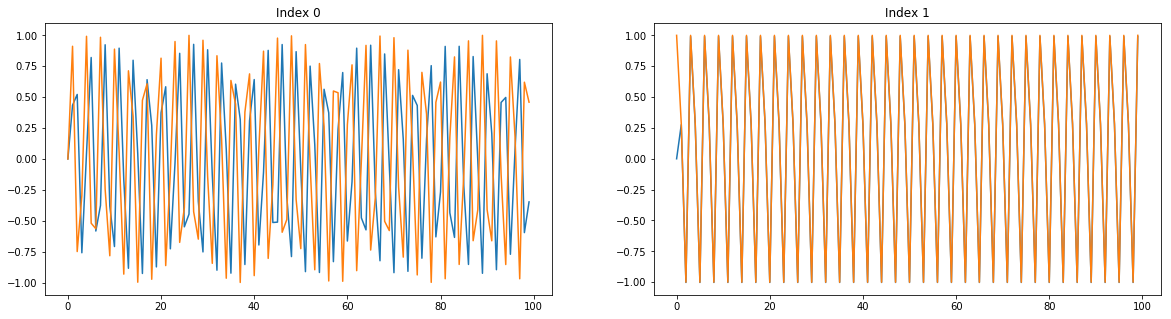

In [165]:

def makeNetwork(p, subr=1, suboff=0):
    signalPlotLength = 15
   # pattern readout learning
    patterns = np.array([1,2])
    
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = np.random.randn(p['N'], 1)
    WbiasRaw = np.random.randn(p['N'], 1)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLengthWout']))
    pCollector = np.zeros((1, p['learnLengthWout']))
    x = np.zeros((p['N'],1))
    
    
    for n in arange(p['washoutLength'] + p['learnLengthWout']):
        u = np.random.randn() * 1.5
        x = np.tanh((Wstar * x) + (Win * u + Wbias))
        if n >= p['washoutLength']:
            xCollector[:, n - p['washoutLength']] = x[:,0]
            pCollector[0, n - p['washoutLength']] = u
                       
#     print("Mean/Max/Min Activations, random network driven by noise")
#     plot(np.mean(xCollector.T, axis=1))
#     plot(np.max(xCollector.T, axis=1))
#     plot(np.min(xCollector.T, axis=1))
    
    Wout = linalg.inv(xCollector.dot(xCollector.conj().T) +  
                  (p['TychonovAlphaReadout'] * np.eye(p['N']))).dot(xCollector).dot(pCollector.conj().transpose()).conj().T

    print("Initial training")
    print("NRMSE: ", nrmse(Wout.dot(xCollector), pCollector))
    print("absWeight: ", mean(abs(Wout)))
    
    allTrainArgs = np.zeros((p['N'], p['patts'].size * p['learnLength']))
    allTrainOldArgs = np.zeros((p['N'], p['patts'].size * p['learnLength']))
    allTrainTargs = np.zeros((p['N'], p['patts'].size * p['learnLength']))
    allTrainOuts = np.zeros((1, p['patts'].size * p['learnLength']))
    xCollectors =  np.zeros((1, p['patts'].size), dtype=np.object)
    SRCollectors =  np.zeros((1, p['patts'].size), dtype=np.object)
    URCollectors =  np.zeros((1, p['patts'].size), dtype=np.object)
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    train_xPL =  np.zeros((1, p['patts'].size), dtype=np.object)
    train_pPL =  np.zeros((1, p['patts'].size), dtype=np.object)
    startXs =  np.zeros((p['N'], p['patts'].size), dtype=np.object)

    for i_pattern in range(p['patts'].size):
        print('Loading pattern ', i_pattern)
        patt = p['patts'][i_pattern]
        xCollector = zeros((p['N'], p['learnLength']))
        xOldCollector = zeros((p['N'], p['learnLength']))
        pCollector = zeros((1, p['learnLength']))
        x = zeros((p['N'],1))
        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt(n+1)
            xOld = x
            x = tanh((Wstar * x) + (Win * u) + Wbias)
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = x[:,0]
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                pCollector[0, n - p['washoutLength']] = u

        xCollectors[0,i_pattern] = xCollector
        R = xCollector.dot(xCollector.T) / p['learnLength']
        patternRs[0,i_pattern] = R

#         [Ux,sx,Vx] = svd(R)
#         SRCollectors[0,i_pattern] = diag(sx)
#         URCollectors[0,i_pattern] = Ux

        startXs[:,i_pattern] = x[:,0]
        
        #needed?
        train_xPL[0,i_pattern] = xCollector[:,:signalPlotLength]
        train_pPL[0,i_pattern] = pCollector[0,:signalPlotLength]
        ###
        
        allTrainArgs[:, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = xCollector
        allTrainOldArgs[:, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = xOldCollector
        allTrainOuts[0, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = pCollector
        allTrainTargs[:, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = Win.dot(pCollector)
         
    Wtargets = np.arctanh(allTrainArgs) - np.tile( Wbias, (1, p['patts'].size * p['learnLength']))

    W = linalg.inv(allTrainOldArgs.dot(allTrainOldArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldArgs).dot(Wtargets.conj().T).conj().T
    pat_NRMSE = mean(nrmse(W.dot(allTrainOldArgs), Wtargets))
    pat_absSize = mean(mean(abs(W), axis=0))
    print("W NRMSE: ", pat_NRMSE)
    print("absSize: ", pat_absSize)
    
#     figure(fig+1)
#     plot(np.mean(W.dot(allTrainOldArgs).T, axis=1))

    print('Computing conceptors, alphas: ', p['alphas'])
    Cs = np.zeros((4, p['patts'].size), dtype=np.object)
    for i_pattern in range(p['patts'].size):
        R = patternRs[0,i_pattern]
        [U,s,V] = svd(R)
        S = diag(s)
        Snew = (S * linalg.inv(S + pow(p['alphas'][i_pattern], -2) * np.eye(p['N'])))

        C =  U.dot(Snew).dot(U.T);
        Cs[0,i_pattern] = C
        Cs[1,i_pattern] = U
        Cs[2,i_pattern] = diag(Snew)
        Cs[3,i_pattern] = diag(S)

    x_CTestPL = np.zeros((3, p['recallTestLength'], p['patts'].size))
    p_CTestPL = np.zeros((1, p['recallTestLength'], p['patts'].size))
    for i_pattern in range(p['patts'].size):
        C = Cs[0,i_pattern]
        x = 0.5 * np.random.randn(p['N'],1)
        for n in range(p['recallTestLength'] + p['washoutLength']):
            x = np.tanh(W.dot(x) + Wbias)
            x = C.dot(x)
            if (n > p['washoutLength']):
                x_CTestPL[:,n-p['washoutLength'],i_pattern] = x[0:3].T
                p_CTestPL[:,n-p['washoutLength'],i_pattern] = Wout.dot(x)
    for i_pattern in range(p['patts'].size):
        ax = subplot(subr, 2, suboff + i_pattern + 1)
        ax.set_title("Index " + str(suboff + i_pattern))
        plot(p_CTestPL[:,:,i_pattern].T)
        plot([p['patts'][i_pattern](x) for x in arange(p['recallTestLength'])])
        
    return locals()

    
params = {'N':100, 'NetSR':1.0, 'NetinpScaling':1.6,'BiasScaling':0.3,'TychonovAlpha':0.0001,
         'washoutLength':200, 'learnLength':8000, 'TychonovAlphaReadout':0.0001,
         'learnLengthWout':1000, 'recallTestLength':100,
         'alphas':np.array([18.0,32.0]),
#          'patts':np.array([lambda x:pLoop(x,p_rw1), lambda x: pLoop(x,p_rw2)])
          'patts':np.array([pJ1, lambda x:pLoop(x,p_rw1)])
         }
figsize(20,5)
net = makeNetwork(params)


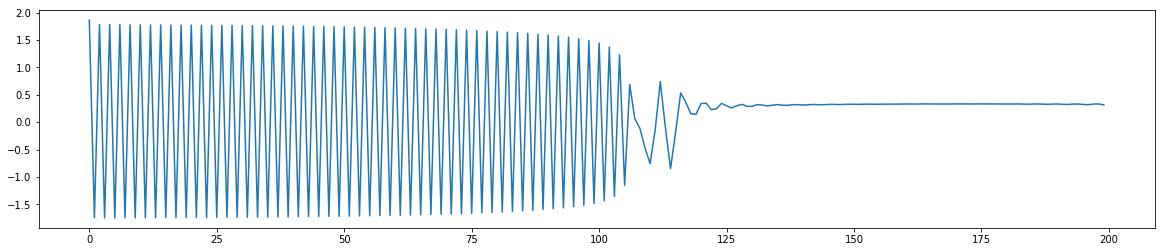

In [35]:
#run a network
figsize(20,4)
runLength = 200
output = np.zeros(runLength)
x = 0.5 * np.random.randn(net['p']['N'],1)
for n in range(runLength):
    pos = ((n / runLength * 2) - 1.0) * 1
    C = (net['Cs'][0,1].dot(pos)) + (net['Cs'][0,0].dot((1.0-pos))) 
#    C = (net['Cs'][0,0] * 0.5) + (net['Cs'][0,1] * 0.5)
#     C = net['Cs'][0,0]
    Wsr = net['W'].dot(1)
    for i_oversample in range(1):
        x = np.tanh(Wsr.dot(x) + net['Wbias'])
        x = C.dot(x)
    #x_CTestPL[:,n-p['washoutLength'],i_pattern] = x[0:3].T
    output[n] = net['Wout'].dot(x)
    
plot(output)

In [242]:
np.random.rand(2) * 100

array([ 70.52237005,  70.04536878])

0
Initial training
NRMSE:  0.000322628724903
absWeight:  0.141449814742
Loading pattern  0
Loading pattern  1
W NRMSE:  0.0710563289259
absSize:  37.8286819588
Computing conceptors, alphas:  [ 74.61883645  90.92657044]
1
Initial training
NRMSE:  0.00039269429997
absWeight:  0.14496354992
Loading pattern  0
Loading pattern  1
W NRMSE:  0.284367928432
absSize:  59.7411697359
Computing conceptors, alphas:  [ 45.97693485  38.18489929]
2
Initial training
NRMSE:  0.000337347140477
absWeight:  0.118904722795
Loading pattern  0
Loading pattern  1
W NRMSE:  0.0426149953593
absSize:  42.3617089418
Computing conceptors, alphas:  [ 11.95049346  16.88551786]
3
Initial training
NRMSE:  0.000249261836951
absWeight:  0.112866116036
Loading pattern  0
Loading pattern  1
W NRMSE:  0.0177282249759
absSize:  11.697560924
Computing conceptors, alphas:  [ 68.75799835  94.35260107]
4
Initial training
NRMSE:  0.000344219251606
absWeight:  0.13171591051
Loading pattern  0
Loading pattern  1
W NRMSE:  0.0462282

W NRMSE:  0.147451488484
absSize:  46.9087814058
Computing conceptors, alphas:  [ 81.95690872  41.88333992]
38
Initial training
NRMSE:  0.0004038001675
absWeight:  0.128969278619
Loading pattern  0
Loading pattern  1
W NRMSE:  0.400341359892
absSize:  77.48338908
Computing conceptors, alphas:  [ 99.77643452  11.34799873]
39
Initial training
NRMSE:  0.000271399082877
absWeight:  0.117930904906
Loading pattern  0
Loading pattern  1
W NRMSE:  0.337366950818
absSize:  49.4385464925
Computing conceptors, alphas:  [ 34.39591664  28.72357637]
40
Initial training
NRMSE:  0.00049909712444
absWeight:  0.179483918595
Loading pattern  0
Loading pattern  1
W NRMSE:  0.208531483678
absSize:  75.4026665687
Computing conceptors, alphas:  [ 50.59078882  54.0185222 ]
41
Initial training
NRMSE:  0.000348712842239
absWeight:  0.133054781822
Loading pattern  0
Loading pattern  1
W NRMSE:  0.00941139604616
absSize:  28.8332799631
Computing conceptors, alphas:  [ 69.88806839  31.6515294 ]
42
Initial training

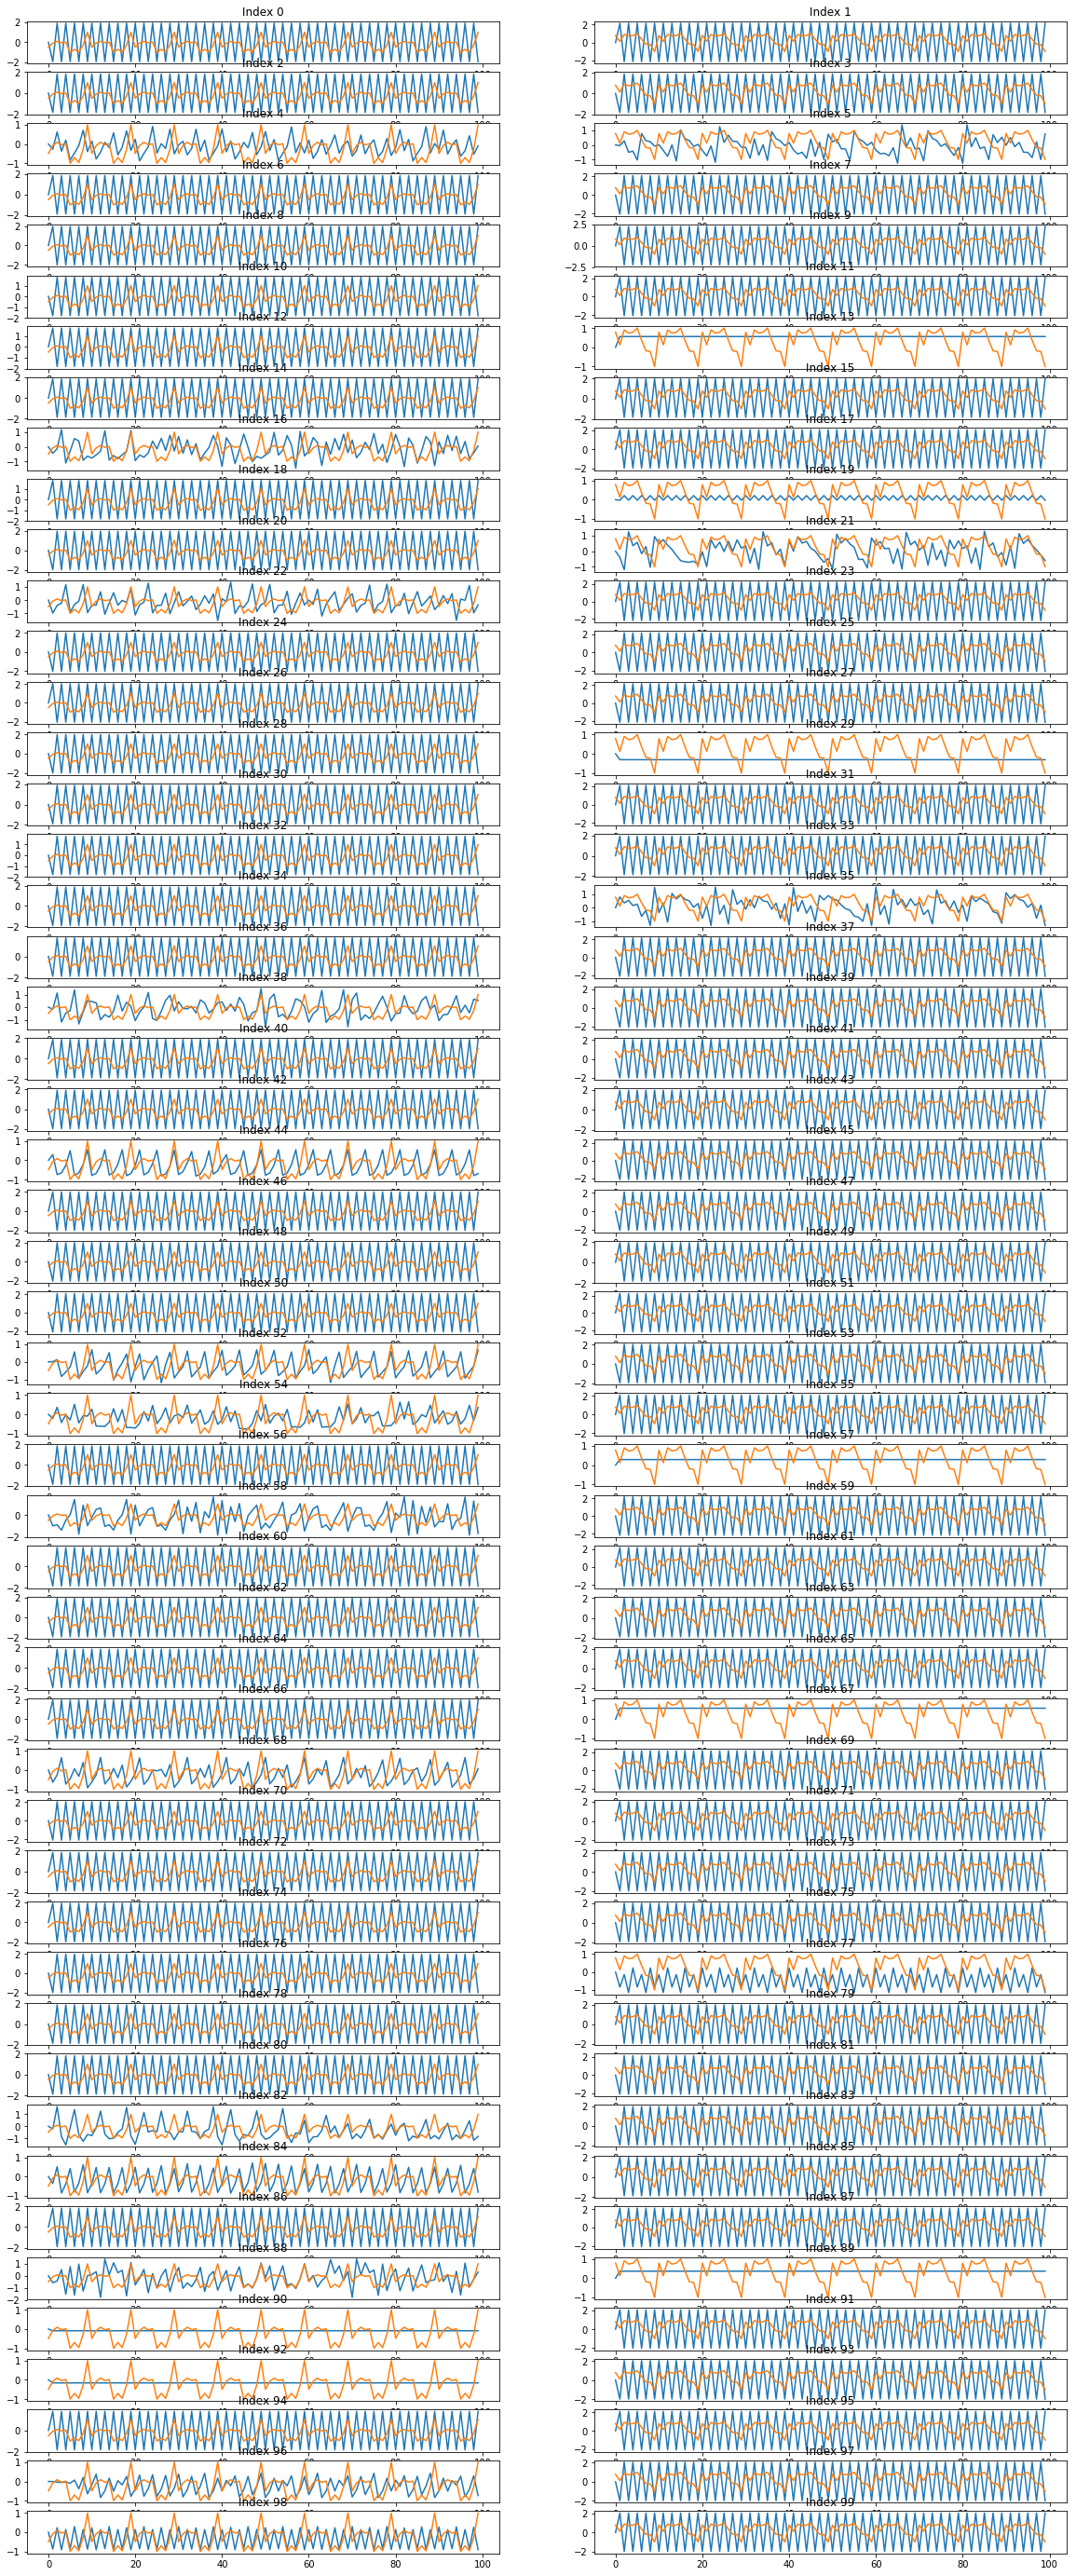

In [285]:
figsize(20,50)
trials = np.zeros(50,dtype = np.object)
for i_trial in range(trials.size):
    print(i_trial)
    params = {'N':200, 'NetSR':1.6, 'NetinpScaling':1.6,'BiasScaling':0.3,'TychonovAlpha':0.0001,
         'washoutLength':200, 'learnLength':8000, 'TychonovAlphaReadout':0.0001,
         'learnLengthWout':1000, 'recallTestLength':100,
         'alphas':np.random.rand(2) * 100,
          'patts':np.array([lambda x:pLoop(x,p_rw1), lambda x: pLoop(x,p_rw2)])
         }

    trials[i_trial] = makeNetwork(params, trials.size, i_trial * 2)

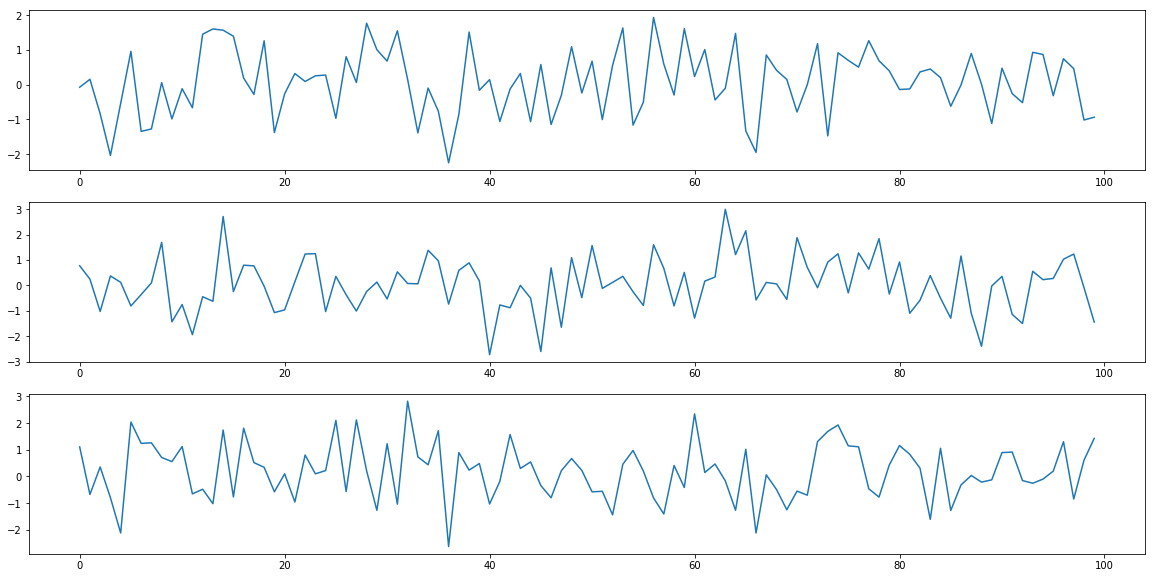

In [259]:
figsize(20,10)
subplot(311)
plot(np.random.randn(100))
subplot(312)
plot(np.random.randn(100))
subplot(313)
plot(np.random.randn(100))

In [ ]:
runOSCServer()

In [ ]:
from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()
jobs.new('runOSCServer()')

In [ ]:
1*9

In [ ]:
jobs.status()

In [ ]:
stopOSC=True

In [ ]:
np.tile( Wbias, (1, patterns.size * learnLength))

In [ ]:
a = zeros((3,5), dtype=np.object)
a[:,3]

In [ ]:
mean(mean(abs(W), axis=0))

In [ ]:
q = np.random.random((3,5))
q

In [ ]:
a[:,0]

In [ ]:
q[:, 0] = a[:,0]

In [ ]:
q

In [ ]:
[U,s,V] = np.linalg.svd(np.ones((3,3)))
print U
print diag(s)
print V.T

In [ ]:
patterns

In [ ]:
#!/usr/bin/env python

from liblo import *
import sys

try:
    server.free()
except:
    pass

class MyServer(ServerThread):
    def __init__(self):
        ServerThread.__init__(self, 2323)

    @make_method('/cx', 'f')
    def cx_callback(self, path, args):
        f = args[0]
        print("received message ",path," with arguments: ", f)
#        send(("127.0.0.1",57120), "/rbn", f*0.8)

    @make_method('/async', 'f')
    def async_callback(self, path, args):
        i = int(args[0])
#        print "received message '%s' with arguments: %i" % (path, i)

    @make_method('/asyncrange', 'f')
    def asyncrange_callback(self, path, args):
        f = args[0]
#        print "received message '%s' with arguments: %i" % (path, i)


    
    @make_method(None, None)
    def fallback(self, path, args):
        print("received unknown message ", s)

try:
    server = MyServer()
except err:
    print(str(err))

server.start()




In [ ]:
#test
try:
    target = Address(2323)
except AddressError as err:
    print (str(err))
    sys.exit()

# send message "/foo/message1" with int, float and string arguments
send(target, "/cx", 0.123)

In [ ]:
figsize(20,10)
# plot([tan(x/0.3) * sin(x/50.0)  * 0.1 for x in arange(1000)], color='purple')
# plot([tan(x/0.15) * 0.1 for x in arange(1000)], color='purple')
for i in range(100):
    plot([sin(x/50.0 + (i/19.0)) * 100.0 for x in arange(1000)], color='blue', alpha=0.3)
    plot([sin(x/50.0) * 50.0 + 100 for x in arange(1000)], color='pink', alpha=0.9)
    plot([sin(x/50.0) * 50.0 for x in arange(1000)], color='purple', alpha=0.5)


0
Initial training
NRMSE:  0.000235711688614
absWeight:  0.127366701664
Loading pattern  0
Loading pattern  1
W NRMSE:  0.48400383152
absSize:  25.8281368052
1
Initial training
NRMSE:  0.000341336095721
absWeight:  0.20480117982
Loading pattern  0
Loading pattern  1
W NRMSE:  0.477708463595
absSize:  32.0355838967
2
Initial training
NRMSE:  0.000372586408346
absWeight:  0.18215866628
Loading pattern  0
Loading pattern  1
W NRMSE:  0.264981809567
absSize:  29.6532056631
3
Initial training
NRMSE:  0.000192686637952
absWeight:  0.161691025786
Loading pattern  0
Loading pattern  1
W NRMSE:  0.475133721509
absSize:  31.3278135003
4
Initial training
NRMSE:  0.000168557735633
absWeight:  0.141186444435
Loading pattern  0
Loading pattern  1
W NRMSE:  0.646778700329
absSize:  16.5648819714
5
Initial training
NRMSE:  0.00016391743865
absWeight:  0.17129785155
Loading pattern  0
Loading pattern  1
W NRMSE:  0.44118524505
absSize:  29.309313198
6
Initial training
NRMSE:  0.000147123503178
absWeigh

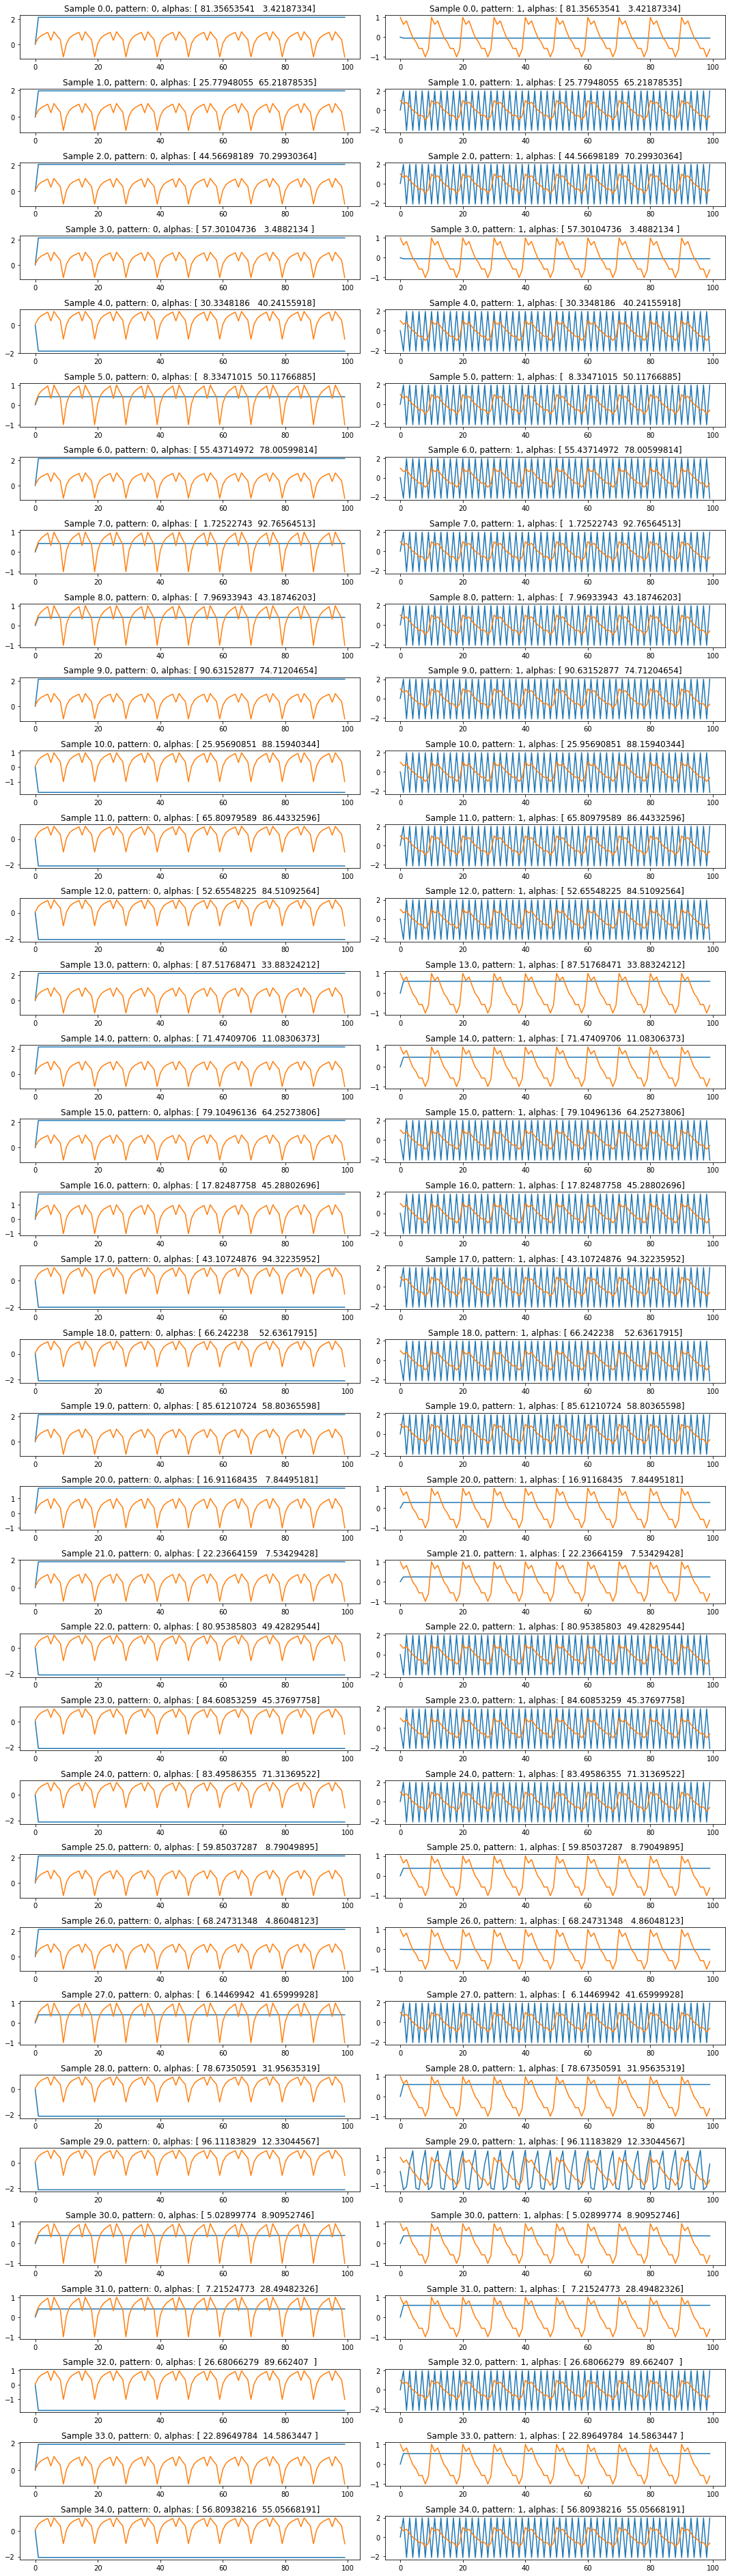

In [219]:

def makeLoadedNetwork(p):
    signalPlotLength = 15
    
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = np.random.randn(p['N'], 1)
    WbiasRaw = np.random.randn(p['N'], 1)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLengthWout']))
    pCollector = np.zeros((1, p['learnLengthWout']))
    x = np.zeros((p['N'],1))
    
    
    for n in arange(p['washoutLength'] + p['learnLengthWout']):
        u = np.random.randn() * 1.5
        xPrev = x
        x = np.tanh((Wstar * x) + (Win * u) + Wbias).dot(1.0 - p['leakRate']) #+ (xPrev.dot(p['leakRate']))
        if n >= p['washoutLength']:
            xCollector[:, n - p['washoutLength']] = x[:,0]
            pCollector[0, n - p['washoutLength']] = u
                       
    Wout = linalg.inv(xCollector.dot(xCollector.conj().T) +  
                  (p['TychonovAlphaReadout'] * np.eye(p['N']))).dot(xCollector).dot(pCollector.conj().transpose()).conj().T

    print("Initial training")
    print("NRMSE: ", nrmse(Wout.dot(xCollector), pCollector))
    print("absWeight: ", mean(abs(Wout)))
    
    allTrainArgs = np.zeros((p['N'], p['patts'].size * p['learnLength']))
    allTrainOldArgs = np.zeros((p['N'], p['patts'].size * p['learnLength']))
    allTrainTargs = np.zeros((p['N'], p['patts'].size * p['learnLength']))
    allTrainOuts = np.zeros((1, p['patts'].size * p['learnLength']))
    xCollectors =  np.zeros((1, p['patts'].size), dtype=np.object)
    SRCollectors =  np.zeros((1, p['patts'].size), dtype=np.object)
    URCollectors =  np.zeros((1, p['patts'].size), dtype=np.object)
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    train_xPL =  np.zeros((1, p['patts'].size), dtype=np.object)
    train_pPL =  np.zeros((1, p['patts'].size), dtype=np.object)
    startXs =  np.zeros((p['N'], p['patts'].size), dtype=np.object)

    for i_pattern in range(p['patts'].size):
        print('Loading pattern ', i_pattern)
        patt = p['patts'][i_pattern]
        xCollector = zeros((p['N'], p['learnLength']))
        xOldCollector = zeros((p['N'], p['learnLength']))
        pCollector = zeros((1, p['learnLength']))
        x = zeros((p['N'],1))
        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt(n+1)
            xOld = x
            x = tanh((Wstar * x) + (Win * u) + Wbias) # + (xOld.dot(p['leakRate']))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = x[:,0]
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                pCollector[0, n - p['washoutLength']] = u

        xCollectors[0,i_pattern] = xCollector
        R = xCollector.dot(xCollector.T) / p['learnLength']
        patternRs[0,i_pattern] = R

        startXs[:,i_pattern] = x[:,0]
        
        #needed?
        train_xPL[0,i_pattern] = xCollector[:,:signalPlotLength]
        train_pPL[0,i_pattern] = pCollector[0,:signalPlotLength]
        ###
        
        allTrainArgs[:, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = xCollector
        allTrainOldArgs[:, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = xOldCollector
        allTrainOuts[0, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = pCollector
        allTrainTargs[:, i_pattern * p['learnLength']:(i_pattern+1) * p['learnLength']] = Win.dot(pCollector)
         
    Wtargets = np.arctanh(allTrainArgs) - np.tile( Wbias, (1, p['patts'].size * p['learnLength']))

    W = linalg.inv(allTrainOldArgs.dot(allTrainOldArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldArgs).dot(Wtargets.conj().T).conj().T
    pat_NRMSE = mean(nrmse(W.dot(allTrainOldArgs), Wtargets))
    pat_absSize = mean(mean(abs(W), axis=0))
    print("W NRMSE: ", pat_NRMSE)
    print("absSize: ", pat_absSize)
    W.dot(allTrainOldArgs)
    
    return locals()

    
# #     figure(fig+1)
# #     plot(np.mean(W.dot(allTrainOldArgs).T, axis=1))

def computeConceptors(p, net, alphas):
    print('Computing conceptors, alphas: ', alphas)
    Cs = np.zeros((4, p['patts'].size), dtype=np.object)
    for i_pattern in range(p['patts'].size):
        R = net['patternRs'][0,i_pattern]
        [U,s,V] = svd(R)
        S = diag(s)
        Snew = (S * linalg.inv(S + pow(alphas[i_pattern], -2) * np.eye(p['N'])))

        C =  U.dot(Snew).dot(U.T);
        Cs[0,i_pattern] = C
        Cs[1,i_pattern] = U
        Cs[2,i_pattern] = diag(Snew)
        Cs[3,i_pattern] = diag(S)
    return locals()
            
def plotConceptorPatterns(p, cNet, subr, suboff, recallTestLength):
    x_CTestPL = np.zeros((3, recallTestLength, p['patts'].size))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].size))
    for i_pattern in range(p['patts'].size):
        C = cNet['Cs'][0,i_pattern]
        x = 0.5 * np.random.randn(p['N'],1)
        xPrev = x
        for n in range(recallTestLength + p['washoutLength']):
            x = np.tanh(cNet['net']['W'].dot(x) + cNet['net']['Wbias']).dot(1.0 - p['leakRate']) + (xPrev.dot(p['leakRate'] ))
            x = C.dot(x)
            xPrev = x
            if (n > p['washoutLength']):
                x_CTestPL[:,n-p['washoutLength'],i_pattern] = x[0:3].T
                p_CTestPL[:,n-p['washoutLength'],i_pattern] = cNet['net']['Wout'].dot(x)
    for i_pattern in range(p['patts'].size):
        ax = subplot(subr, 2, suboff + i_pattern + 1)
        ax.set_title("Sample " + str(suboff/2) + ", pattern: " + str(i_pattern) + ", alphas: " + str(cNet['alphas']))
        plot(p_CTestPL[:,:,i_pattern].T)
        plot([p['patts'][i_pattern](x) for x in arange(recallTestLength)])
        

    
params = {'N':100, 'NetSR':1.3, 'NetinpScaling':0.9,'BiasScaling':0.8,'TychonovAlpha':0.0001,
         'washoutLength':300, 'learnLength':1000, 'TychonovAlphaReadout':0.0001,
          'leakRate': 0.0,
         'learnLengthWout':1000, 
          'patts':np.array([lambda x:pLoop(x,p_rw1), lambda x: pLoop(x,p_rw2)])
#          'patts':np.array([pJ1, pJ2])
         }


sampleSize = 10
loadedNets = np.zeros(sampleSize, dtype=np.object)
for i_net, net in enumerate(loadedNets):
    print(i_net)
    loadedNets[i_net] = makeLoadedNetwork(params)
nrmses = [x['pat_NRMSE'] for x in loadedNets]
bestNetwork = np.argmin(nrmses)
print("NRMSEs: best: ", loadedNets[bestNetwork]['pat_NRMSE'], "avg: ", np.mean(nrmses) )

conceptorSampleSize = 35
conceptorNets = np.zeros(conceptorSampleSize, dtype=np.object)
figsize(15,conceptorSampleSize * 1.5)
for i_cnet in range(conceptorSampleSize):
    conceptorNets[i_cnet] = computeConceptors(params, loadedNets[bestNetwork], np.random.random(2) * 100)
    plotConceptorPatterns(params, conceptorNets[i_cnet], conceptorSampleSize, i_cnet * 2, 100)
plt.tight_layout();


In [189]:
a = np.random.random((3,3))
print(a)

[[ 0.70655943  0.76079473  0.36199111]
 [ 0.88889846  0.70033213  0.34483712]
 [ 0.67154548  0.92403546  0.51764446]]


In [194]:
a * np.array(10)

array([[ 7.0655943 ,  7.6079473 ,  3.61991108],
       [ 8.88898457,  7.00332125,  3.44837119],
       [ 6.71545484,  9.24035464,  5.17644461]])